In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import gpytorch
from tqdm.notebook import trange
import heapq
import math
import pickle
import itertools
from utils.class_imbalance import get_classes, class_proportion

from algorithms.cgm import *

## Dataset

In [3]:
def sample_GMM(means, covs, num_samples):
    """
    Samples equally from clusters of normal distributions.
    """
    assert(means.shape[0] == covs.shape[0])
    assert(means.shape[1] == covs.shape[1])
    assert(covs.shape[1] == covs.shape[2])
    
    n = means.shape[0]
    d = means.shape[1]
    samples = np.zeros((num_samples, d))
    clusters = np.zeros(num_samples, dtype=np.int32)
    
    for i in range(num_samples):
        cluster = np.random.randint(n)
        samples[i] = np.random.multivariate_normal(means[cluster], covs[cluster], check_valid='raise')
        clusters[i] = cluster
    
    return samples, clusters

In [4]:
num_clusters = 5
d = 2
num_samples = 1000

In [5]:
np.random.seed(2)

In [6]:
means = np.random.uniform(size=(num_clusters, d))
covs = np.zeros((num_clusters, d, d))
for i in range(num_clusters):
    covs[i] = np.eye(d)/200

In [7]:
train_sets = np.zeros((num_clusters, num_samples, d))
test_sets = np.zeros((num_clusters, num_samples, d))

In [8]:
for i in range(num_clusters):
    train_sets[i] = np.random.multivariate_normal(means[i], covs[i], size=(num_samples), check_valid='raise')
    test_sets[i] = np.random.multivariate_normal(means[i], covs[i], size=(num_samples), check_valid='raise')

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
for i in range(num_clusters):
    plt.scatter(train_sets[i, :, 0], train_sets[i, :, 1], s=2, color=cm.get_cmap('Set1')(i*(1/9)), label="{0}".format(i))
    plt.legend()

## Equal disjoint

In [10]:
num_parties = 5

In [11]:
disjoint_prop = np.eye(5)

In [12]:
party_datasets = split_proportions(train_sets, disjoint_prop)

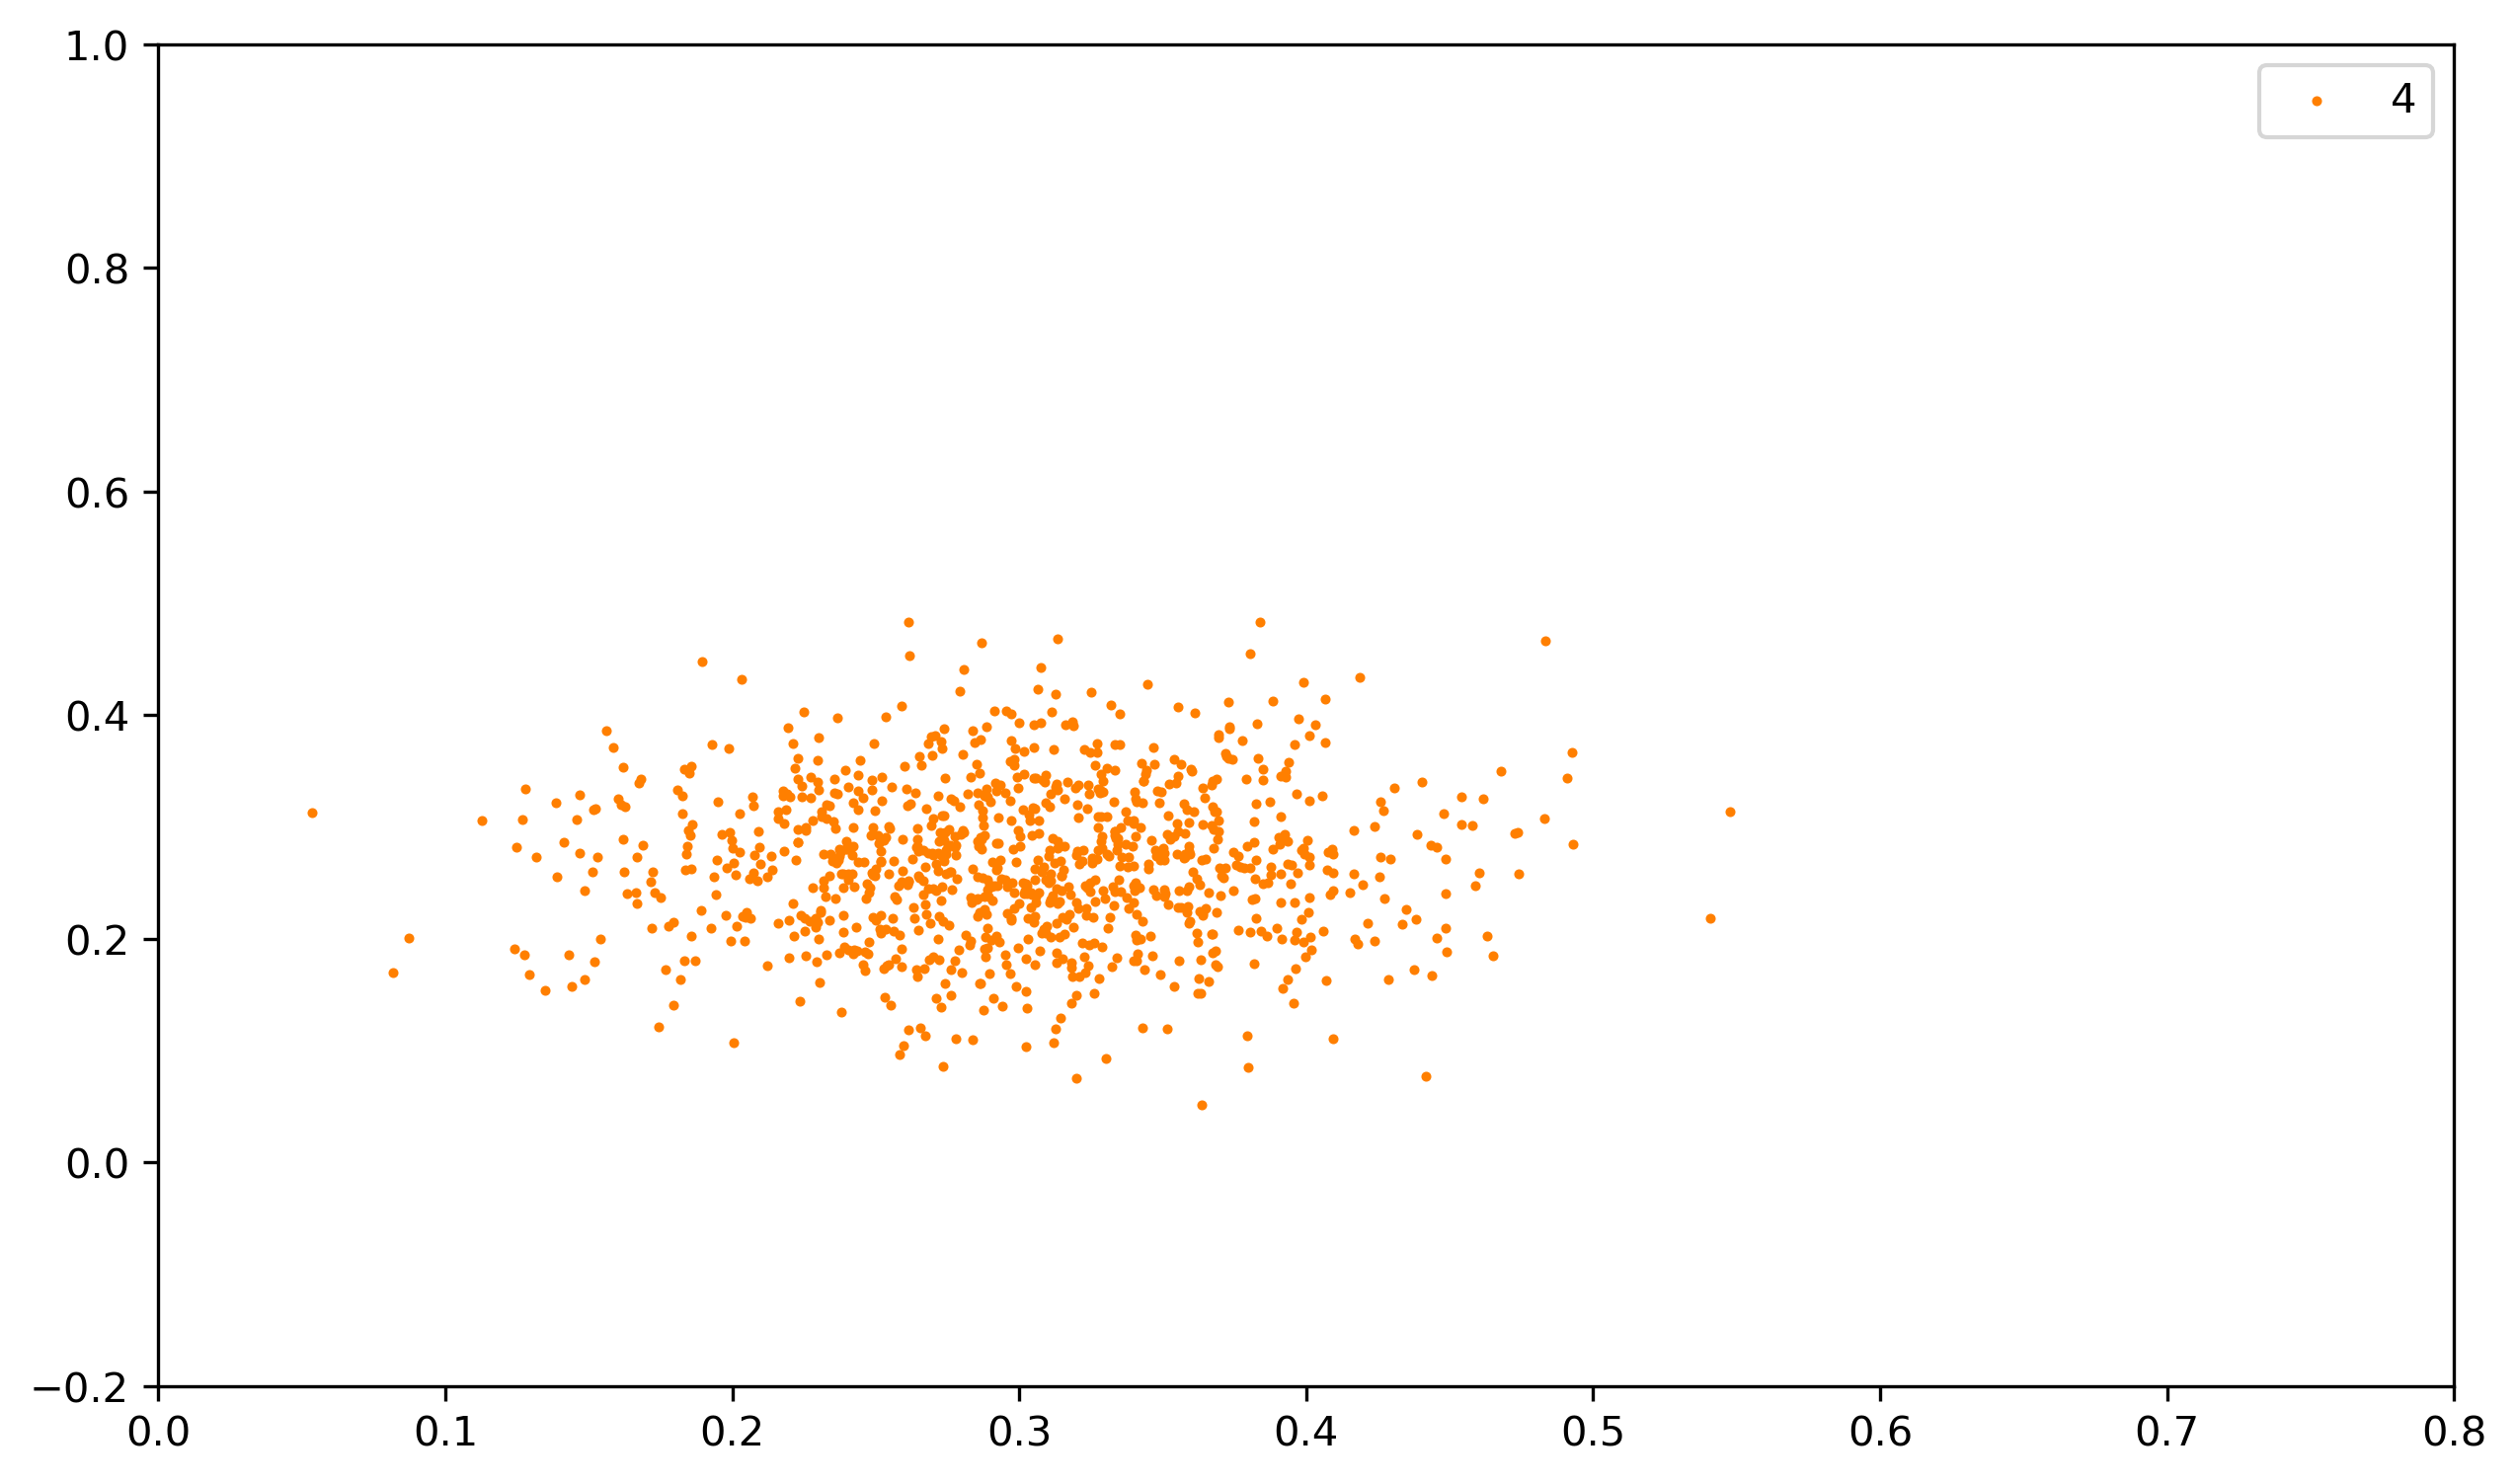

In [13]:
# Check
plt.figure(figsize=(10, 6), dpi=300)
plt.xlim(0, 0.8)
plt.ylim(-0.2, 1.0)
for i in range(num_parties):
    if i == 4:
        plt.scatter(party_datasets[i, :, 0], party_datasets[i, :, 1], s=2, color=cm.get_cmap('Set1')(i*(1/9)), label="{0}".format(i))

plt.legend()

In [85]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=d))
kernel.base_kernel.lengthscale = [0.05, 0.05]
kernel.outputscale = 1

In [86]:
reference_dataset, reference_labels = sample_GMM(means, covs, num_samples=5000)

In [87]:
perm_samp_dataset, perm_samp_labels = sample_GMM(means, covs, num_samples=5000)

In [88]:
v = get_v(party_datasets, reference_dataset, kernel)

In [90]:
v

{'{1}': -0.12176194787025452,
 '{2}': -0.09731973707675934,
 '{3}': -0.05684858560562134,
 '{4}': -0.12243092060089111,
 '{5}': -0.07584540545940399,
 '{1, 2}': -0.005384087562561035,
 '{1, 3}': 0.013780422508716583,
 '{1, 4}': -0.01895681768655777,
 '{1, 5}': -2.5831162929534912e-05,
 '{2, 3}': -0.007432505488395691,
 '{2, 4}': -0.007545769214630127,
 '{2, 5}': 0.012476705014705658,
 '{3, 4}': 0.013000614941120148,
 '{3, 5}': -0.013505026698112488,
 '{4, 5}': 0.0015674829483032227,
 '{1, 2, 3}': 0.031087294220924377,
 '{1, 2, 4}': 0.023773998022079468,
 '{1, 2, 5}': 0.035910464823246,
 '{1, 3, 4}': 0.03692648559808731,
 '{1, 3, 5}': 0.028383813798427582,
 '{1, 4, 5}': 0.02781973034143448,
 '{2, 3, 4}': 0.02985428273677826,
 '{2, 3, 5}': 0.021796710789203644,
 '{2, 4, 5}': 0.03573218733072281,
 '{3, 4, 5}': 0.02881968766450882,
 '{1, 2, 3, 4}': 0.04666062816977501,
 '{1, 2, 3, 5}': 0.04394938796758652,
 '{1, 2, 4, 5}': 0.04770266264677048,
 '{1, 3, 4, 5}': 0.04607606679201126,
 '{2, 3,

In [91]:
phi = shapley(v, num_parties)
print(phi)

[0.004584805108606815, 0.009846480873723825, 0.020594494727750618, 0.0041605715329448385, 0.015794477115074795]


In [92]:
alpha = norm(phi)
print(alpha)

[0.2226228499031294, 0.4781122821360562, 1.0, 0.20202348190356728, 0.76692714843798]


In [93]:
etas = [0.001, 0.01, 0.1, 1]

In [94]:
# all_sorted_vX = []
# for eta in etas:
#     sorted_vX = perm_sampling_neg_biased(perm_samp_dataset, reference_dataset, kernel, num_perms=200, eta=eta)
#     all_sorted_vX.append(sorted_vX)
#     print("Eta = {} - Mean:{} \\ Median:{}".format(eta, np.mean(sorted_vX), np.median(sorted_vX)))

In [95]:
vN = get_vN(v, num_parties)
print(vN)

0.05498082935810089


In [96]:
v_is = get_v_is(v, num_parties)
print(v_is)

[-0.12176194787025452, -0.09731973707675934, -0.05684858560562134, -0.12243092060089111, -0.07584540545940399]


In [97]:
get_alpha_min(alpha)

0.20202348190356728

## All condition

In [98]:
best_eta, q = get_eta_q(vN, alpha, v_is, perm_samp_dataset, reference_dataset, kernel, mode="all")


Iteration 0
current_high=1.0, current_low=0.001
Evaluating for eta = 0.5005



all condition satisfied, setting current_high to 0.5005
Iteration 1
current_high=0.5005, current_low=0.001
Evaluating for eta = 0.25075



all condition satisfied, setting current_high to 0.25075
Iteration 2
current_high=0.25075, current_low=0.001
Evaluating for eta = 0.125875



all condition satisfied, setting current_high to 0.125875
Iteration 3
current_high=0.125875, current_low=0.001
Evaluating for eta = 0.0634375



all condition satisfied, setting current_high to 0.0634375
Iteration 4
current_high=0.0634375, current_low=0.001
Evaluating for eta = 0.03221875



all condition satisfied, setting current_high to 0.03221875
Iteration 5
current_high=0.03221875, current_low=0.001
Evaluating for eta = 0.016609375



all condition satisfied, setting current_high to 0.016609375
Iteration 6
current_high=0.016609375, current_low=0.001
Evaluating for eta = 0.0088046875



all condition satisfied, setting current_high to 0.0088046875
Iteration 7
current_high=0.0088046875, current_low=0.001
Evaluating for eta = 0.00490234375



all condition satisfied, setting current_high to 0.00490234375
Iteration 8
current_high=0.00490234375, current_low=0.001
Evaluating for eta = 0.002951171875



all condition satisfied, setting current_high to 0.002951171875
Iteration 9
current_high=0.002951171875, current_low=0.001
Evaluating for eta = 0.0019755859374999997



all condition satisfied, setting current_high to 0.0019755859374999997


In [99]:
best_eta

0.0019755859374999997

In [100]:
v_is

[-0.12176194787025452,
 -0.09731973707675934,
 -0.05684858560562134,
 -0.12243092060089111,
 -0.07584540545940399]

In [101]:
#all condition
r = list(map(q, alpha))
print(r)

[-0.0777200311422348, -0.047859132289886475, 0.05498082935810089, -0.07858599722385406, -0.017962336540222168]


In [102]:
num_candidate_points = 5000
gmm_clusters = [sample_GMM(means, covs, num_candidate_points) for i in range(num_clusters)]
gmm = np.array([pair[0] for pair in gmm_clusters])
clusters = np.array([pair[1] for pair in gmm_clusters])
cand_datasets = np.array([gmm[0]]*num_parties)

In [103]:
greeds = np.ones(num_parties) * 2

In [ ]:
rewards, deltas, mus = reward_realization(cand_datasets, 
                                          reference_dataset, 
                                          r, 
                                          party_datasets, 
                                          kernel, 
                                          greeds=greeds)

Running weighted sampling algorithm with -MMD^2 target -0.047859132289886475
Running weighted sampling algorithm with -MMD^2 target -0.0777200311422348Running weighted sampling algorithm with -MMD^2 target 0.05498082935810089
Running weighted sampling algorithm with -MMD^2 target -0.017962336540222168Running weighted sampling algorithm with -MMD^2 target -0.07858599722385406




In [ ]:
pickle.dump((gmm, clusters, reference_dataset, cand_datasets, party_datasets, greeds, rewards, deltas, mus), open("results/CGM-GMM-equaldisjoint-greed2-all.p", "wb"))

In [ ]:
class_props = []
for result in rewards:
        class_props.append(class_proportion(get_classes(np.array(result), gmm[0], clusters[0]), num_clusters))

In [ ]:
class_props

In [ ]:
for i in range(num_parties):
    print(mmd_neg_biased(np.concatenate([party_datasets[i], np.array(rewards[i])], axis=0), reference_dataset, kernel)[0])

## Max condition

In [ ]:
best_eta, q = get_eta_q(vN, alpha, v_is, mode="max")

In [ ]:
best_eta

In [ ]:
v_is

In [ ]:
#all condition
r = list(map(q, alpha))
print(r)

In [ ]:
rewards, deltas, mus = reward_realization(cand_datasets, 
                                          reference_dataset, 
                                          r, 
                                          party_datasets, 
                                          kernel, 
                                          greeds=greeds)

In [ ]:
num_candidate_points = 5000
gmm_clusters = [sample_GMM(means, covs, num_candidate_points) for i in range(num_clusters)]
gmm = np.array([pair[0] for pair in gmm_clusters])
clusters = np.array([pair[1] for pair in gmm_clusters])
cand_datasets = np.array([gmm[0]]*num_parties)

In [ ]:
greeds = np.ones(num_parties) * 2

In [ ]:
pickle.dump((gmm, clusters, reference_dataset, cand_datasets, party_datasets, greeds, rewards, deltas, mus), open("results/CGM-GMM-equaldisjoint-greed2-max.p", "wb"))

In [ ]:
class_props = []
for result in rewards:
        class_props.append(class_proportion(get_classes(np.array(result), gmm[0], clusters[0]), num_clusters))

In [ ]:
class_props

In [ ]:
for i in range(num_parties):
    print(mmd_neg_biased(np.concatenate([party_datasets[i], np.array(rewards[i])], axis=0), reference_dataset, kernel)[0])